# Planets Images Generation using Deep Convolutional Generative Adversarial Networks

#### Final Project: Tópicos Avanzados en Estadística 1
#### Universidad Nacional de Colombia

__Integrantes:__ Andres Acevedo & Angel Martínez

In [2]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import PIL
import time
import glob
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

## Loading the Dataset

In [3]:
# Data augmentation for the training dataset images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True)

In [4]:
# Loading the planets images dataset (augmented)
BATCH_SIZE = 256
IMAGE_SIZE = 80

image_generator = train_datagen.flow_from_directory('/kaggle/input/solar-system-planets/planetsdataset_completo/training',
                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                 batch_size=BATCH_SIZE,
                                 class_mode='sparse')

Found 1834 images belonging to 9 classes.


In [5]:
image_generator.class_indices

{'earth': 0,
 'jupiter': 1,
 'mars': 2,
 'mercury': 3,
 'neptune': 4,
 'pluto': 5,
 'saturn': 6,
 'uranus': 7,
 'venus': 8}

In [6]:
for batch in image_generator:
    print(batch[1].shape)
    print(sum([batch[0][batch[1] == i].shape[0] for i in [0., 1., 2., 3., 4., 5., 6., 7., 8.]]))
    break

(256,)
256


In [7]:
# Load all the generated images in NumPy tensors (filtering the desired class)
class_index_to_select = 0.  # only images of the earth
selected_images = []

for batch in image_generator:
    batch_labels = batch[1]  # Obtaining the labels (index 1)
    mask = (batch_labels == class_index_to_select)
    selected_batch = batch[0][mask]  # Filtering the images by label
    selected_images.append(selected_batch)
    print(selected_batch[0].shape)
    
    if len(selected_images) * BATCH_SIZE >= len(image_generator.filenames):
        break

images = tf.concat(selected_images, axis=0)  # Concat every batch

# Numpy tensor shape
print("Tensores de imágenes:", images.shape)

# Creating a Dataset from the Numpy tensor
BUFFER_SIZE = 1834  # Computer RAM size for temporaly storage
BATCH_SIZE = 256

# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
Tensores de imágenes: (220, 80, 80, 3)


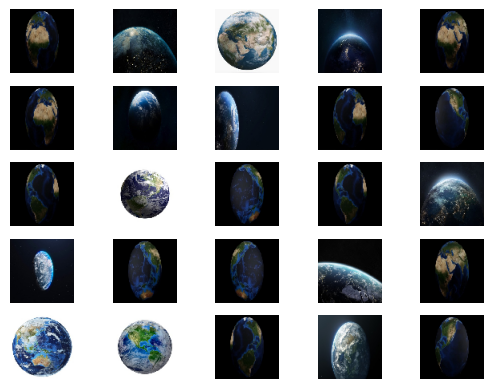

In [8]:
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(images[i])
plt.show()

---

## Defining the Model

In [9]:
# Defining the generator

LATENT_DIM = 100

def make_generator_model(latent_dim = LATENT_DIM):
  i = Input(shape=(latent_dim, ))  # (latent_dim, ) -> (100, )

  x = Dense(IMAGE_SIZE//4 * IMAGE_SIZE//4 * 256, use_bias=False)(i)  # (20 * 20 * 256, )
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Reshape((IMAGE_SIZE//4, IMAGE_SIZE//4, 256))(x)  # (20, 20, 256)
    
  x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)  # (20, 20, 128)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)  # (40, 40, 64)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')(x)  # (80, 80, 3) -> generated image

  model = Model(i, x)
  return model

In [10]:
generator = make_generator_model()

# Generator Network Architecture
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 102400)            10240000  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 20, 20, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 128)      819200    
 nspose)                                                     

(1, 80, 80, 3)


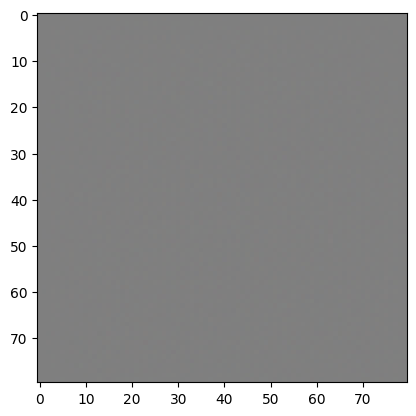

In [11]:
# Using the generator (still untrained) to create an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(generated_image.shape)
#plt.imshow(generated_image[0], cmap='gray')
plt.imshow(generated_image[0])

In [12]:
# Defining the discriminator

def make_discriminator_model():
  i = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])  # (80, 80, 3)

  x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='leaky_relu')(i)  # (40, 40, 64)
  x = Dropout(0.3)(x)
        
  x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='leaky_relu')(x)  # (20, 20, 128)
  x = Dropout(0.3)(x)

  x = Flatten()(x)  # (20 * 20 * 128, )
  x = Dense(1)(x)  # (1, ) -> real or fake

  model = Model(i, x)
  return model

In [13]:
discriminator = make_discriminator_model()

# Discriminator Network Architecture
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 40, 40, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 128)       204928    
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 128)       0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5120

In [14]:
# Using the discriminator (still untrained) to classify the generated images as real or fake
decision = discriminator(generated_image)
print(decision)  # Note that the discriminator is sure it is fake (0% prob. to be real)

tf.Tensor([[0.10671227]], shape=(1, 1), dtype=float32)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [16]:
# Saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
# Defining the training cycle

EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # This computes the generator and discriminator gradients

    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # Generator gradients
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # Discriminator gradients

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # Optimizing generator params
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # Optimizing discriminator params

In [18]:
# Generating and saving images for a given epoch

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False
  # This is so all layers run in inference mode (batchnorm)
  predictions = model(test_input, training=False)  # Generated image from a given seed in a trained model

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [19]:
######################
### TRAINING CYCLE ###
######################

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()  # Starting time

    for image_batch in dataset:
      train_step(image_batch)
    
    # show the generated image every 100 epochs
    if (epoch + 1) % 100 == 0:
      # Produce images for the GIF as you go
      display.clear_output(wait=True)  # It doesn't shows the NN training outputs
      generate_and_save_images(generator,
                               epoch + 1,
                               seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))  # It only shows the time spent in each epoch

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # Save the model
  checkpoint.save(file_prefix = checkpoint_prefix)

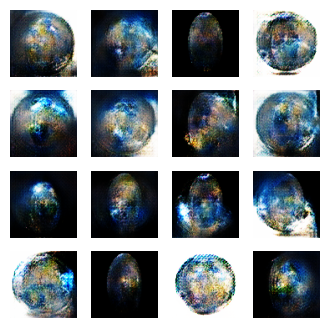

In [20]:
# Training the Model (generator and discriminator simultaneously)
train(dataset, EPOCHS)

In [21]:
# Restoring the last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

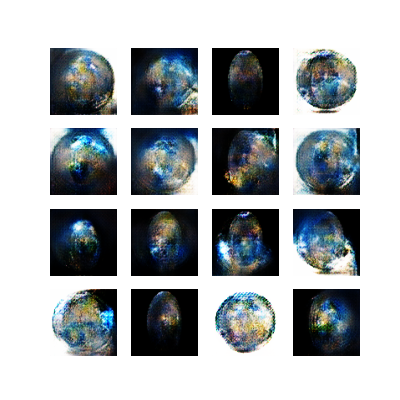

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)  # Last image generated (at the final epoch)

In [23]:
# Creating a GIF using imageio with the images saved during the training
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_32/2676814339.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_32/2676814339.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [24]:
%pip install tensorflow_docs  # This is required to shows the aminated GIF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



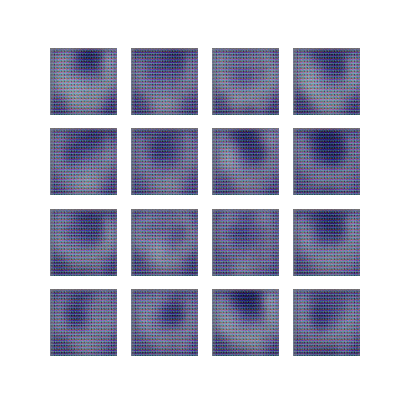

In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)  # This shows the aminated GIF

### The END!